In [331]:
from matplotlib import rcParams
rcParams['font.family'] = 'arial'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import cm
from matplotlib import pyplot, transforms
from numpy import linspace

In [333]:
print(__doc__)

# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

from sklearn import preprocessing

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve

from tqdm import tqdm 

import warnings
warnings.filterwarnings('ignore')

Automatically created module for IPython interactive environment


In [343]:
#reads in all literature data unfiltered
data = pd.read_csv('data_h2o_all.csv')

In [345]:
#temp profiles of uranus and neptune
neptune = pd.read_csv('neptune.csv')
uranus = pd.read_csv('uranus.csv')

In [347]:
data

,P (GPa),T (K),Phase,Ref,Method,Comment,w/o thermal P
0,21.00,895.00,superionic-bcc,P21,DAC,NaN,NaN
1,21.00,940.00,superionic-bcc,P21,DAC,NaN,NaN
2,21.00,950.00,superionic-bcc,P21,DAC,NaN,NaN
3,21.00,300.00,ice-VII,P21,DAC,NaN,NaN
4,21.00,635.00,ice-VII,P21,DAC,NaN,NaN
...,...,...,...,...,...,...,...
1341,44.43,1840.31,liquid,NaN,NaN,NaN,NaN
1342,79.46,2437.62,liquid,NaN,NaN,NaN,NaN
1343,79.46,2437.62,liquid,NaN,NaN,NaN,NaN
1344,83.48,2442.62,liquid,NaN,NaN,NaN,NaN


In [349]:
data07 = data[data['Phase']=='ice-VII']
#data07d = data[data['Phase']=='ice-VII-d']
data06 = data[data['Phase']=='Ice VI']
data08 = data[data['Phase']=='ice-VIII']
data03 = data[data['Phase']=='Ice III']
data05 = data[data['Phase']=='Ice V']
dataih = data[data['Phase']=='Ice-Ih']
data02 = data[data['Phase']=='ice ii']

data21 = data.loc[((data['Phase']=='bcc') | (data['Phase']=='ice-X') | (data['Phase']=='ice-VII-d') | (data['Phase']=='ice-VII'))]
#data21 = data.loc[((data['Phase']=='bcc') | (data['Phase']=='ice-X') | (data['Phase']=='ice-VII-d'))] #find entries where column is 'ice x'
data21['Phase'] = 'bcc' #changes all the names ^^ to bcc to group them
# df.loc[((df['col1'] > 10) | (df['col2'] < 8))] 
data0l = data[data['Phase']=='liquid']
data0bccSI = data[data['Phase']=='superionic-bcc']
data0fccSI = data[data['Phase']=='superionic-fcc']

data0 = pd.concat([data0l, dataih, data02, data03, data05, data06, data07, data08, data21, data0bccSI, data0fccSI], ignore_index=True, axis=0) #regroups chosen phases        
            

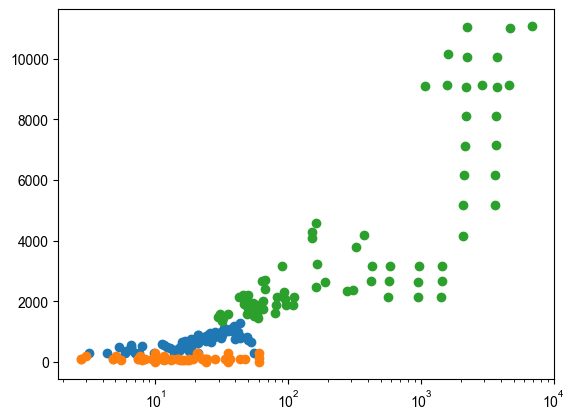

In [351]:
plt.scatter(data07["P (GPa)"], data07["T (K)"])
plt.scatter(data08["P (GPa)"], data08["T (K)"])
plt.scatter(data0fccSI["P (GPa)"], data0fccSI["T (K)"])
plt.xscale("log")

In [353]:
#data0 = data0[(data0['P (GPa)']<=10000)&(data0['T (K)']<=10000)]
#data0 = data0[data0['Ref']!='F16']

In [355]:
data0['Phase'].unique() #checking unique entries in phase column (like bcc and fcc to describe lattice structure)

array(['liquid', 'Ice-Ih', 'ice ii', 'Ice III', 'Ice V', 'Ice VI',
       'ice-VII', 'ice-VIII', 'bcc', 'superionic-bcc', 'superionic-fcc'],
      dtype=object)

In [357]:
le = preprocessing.LabelEncoder()
le.fit(data0[['Phase']])
list(le.classes_)
#prepares data to put into machine learning, organizes input

['Ice III',
 'Ice V',
 'Ice VI',
 'Ice-Ih',
 'bcc',
 'ice ii',
 'ice-VII',
 'ice-VIII',
 'liquid',
 'superionic-bcc',
 'superionic-fcc']

In [359]:
data0['PhaseLabel'] = le.transform(data0[['Phase']]) #transform labels into numbers


In [361]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
newcolors = np.array(['#00A3FF',
                      '#00CCFF',
                      '#007AFF',
                      'w',
                      '#0052FF',
                      '#0000FF',
                      '#0C40B0',
                      '#0F3891',
                      '#4f90c2',
                      '#0b4c7d',
                      '#274ea8',
                      '#6c73e0',
                      '#2e2aa8'
])
#cm.Paired([3,1,2])
phase_colors= ListedColormap(newcolors, name='he') #classifies colors to phases

In [363]:
phase_colors_dict={0:'#00A3FF',1:'#00CCFF',2:'#007AFF',3:'w',4:'#0052FF', 5:'#0C40B0',6:'#0F3891',7:'#4f90c2',8:'#0b4c7d',9:'#274ea8', 10:'#6c73e0',11:'#2e2aa8'}

In [365]:
phase_colors_dict[0]

'#00A3FF'

In [367]:
data0

,P (GPa),T (K),Phase,Ref,Method,Comment,w/o thermal P,PhaseLabel
0,77.0,4000.0,liquid,P21,NaN,NaN,66.8,8
1,54.5,2500.0,liquid,P21,NaN,NaN,48.8,8
2,64.0,3200.0,liquid,P21,NaN,NaN,56.0,8
3,49.5,2300.0,liquid,P21,NaN,NaN,45.0,8
4,25.0,1350.0,liquid,P21,NaN,NaN,NaN,8
...,...,...,...,...,...,...,...,...
1419,278.0,2340.0,superionic-fcc,M19,shock,NaN,NaN,10
1420,309.0,2380.0,superionic-fcc,M19,shock,NaN,NaN,10
1421,420.0,2680.0,superionic-fcc,M19,shock,NaN,NaN,10
1422,164.0,3230.0,superionic-fcc,M19,shock,NaN,NaN,10


In [369]:
#axes[0].set_xlim([10,1000])
#axes[0].set_ylim([1000,10000])

In [371]:
data0 = data0[(data0['P (GPa)']<=500)] #We don't need >500 GPa for Uranus specifically

In [373]:
#data0 = data0[(data0['P (GPa)']<=10000)&((data0['T (K)']<=200000))]

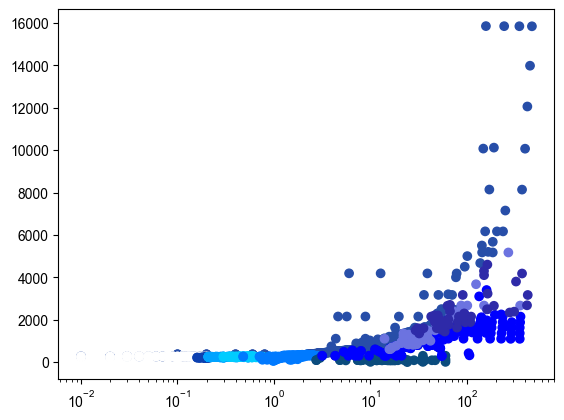

In [375]:
plt.scatter(data0['P (GPa)'],data0['T (K)'],cmap=phase_colors, c= data0['PhaseLabel'])
plt.xscale("log")

logistic regression

In [378]:
X = data0[['P (GPa)','T (K)']]
degree = 2 #second order polynomial
X_poly = PolynomialFeatures(degree=degree,include_bias=False).fit_transform(X) #multiplies P and T to plug into higher order
Y = data0['PhaseLabel']
#preparing data before log regression

In [380]:
model = LogisticRegression(C= 10000, class_weight ='balanced'
                           , multi_class= 'ovr', penalty= 'l1', solver= 'liblinear'
                           ,random_state = 2023)
#model = LogisticRegressionCV(class_weight =None, multi_class = 'ovr', penalty = 'l1', solver = 'liblinear')
#labels for the best combination
modelfit = model.fit(X_poly, Y) #predict values and put into modelfit

In [381]:
sparsity = np.mean(modelfit.coef_ == 0) * 100 #correlations of model
print(sparsity)

0.0


In [384]:
modelfit.coef_

array([[-7.84676170e-01,  4.84864846e-04, -1.96230726e-01,
         5.14987379e-04, -1.53110509e-05],
       [ 3.60585680e-01, -1.65154802e-04, -2.07030833e-01,
         1.62639942e-04, -9.38079631e-06],
       [ 1.37914936e+00, -2.62009782e-03, -2.24722002e-01,
         8.78545320e-04, -1.62277260e-05],
       [-1.10554588e+01, -3.88446967e-03, -1.06488032e-01,
         4.17981564e-04, -7.77871743e-07],
       [ 9.56192976e-02,  3.62616349e-03, -2.56178406e-04,
         1.13082177e-05, -2.86654248e-06],
       [-1.47159616e+00, -3.10830162e-03, -1.59954901e-01,
        -3.07222658e-04, -3.15676806e-05],
       [ 2.94002509e-01,  8.67772112e-03, -6.43298003e-03,
         2.06309707e-04, -1.24306927e-05],
       [ 6.25602915e-01, -1.43369233e-02, -7.85059474e-03,
        -1.12701096e-04, -5.40896550e-05],
       [-3.81774460e-01,  1.24939375e-02,  6.93100407e-04,
         3.25646467e-06, -6.05358106e-07],
       [-4.10449225e-02,  5.78457820e-03, -9.34487757e-05,
         2.71673185e-05

In [386]:
pv, tv = np.meshgrid(np.linspace(0, 400, 1600,endpoint=True), np.linspace(50, 6000, 5500,endpoint=True)) #prepares matrix to plot model


In [388]:
X_pred = np.c_[pv.ravel(), tv.ravel()] #turns mesh into columns
X_pred_poly = PolynomialFeatures(degree=degree,include_bias=False).fit_transform(X_pred)

In [389]:
Y_hat = modelfit.predict(X_pred_poly)
Y_proba_hat = modelfit.predict_proba(X_pred_poly)

In [390]:
from matplotlib import ticker, cm
wd_c = ['#d1495b']
rw_c = ['#00798c']
pv_c = ['#edae49']

In [392]:
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# newcolors = np.array(['#d1495b',
#                       '#00798c',
#                       '#edae49'
# ])
# #cm.Paired([3,1,2])
# phase_colors= ListedColormap(newcolors, name='mg2sio4')

In [393]:
from matplotlib.legend_handler import HandlerTuple

In [394]:
from sklearn import linear_model

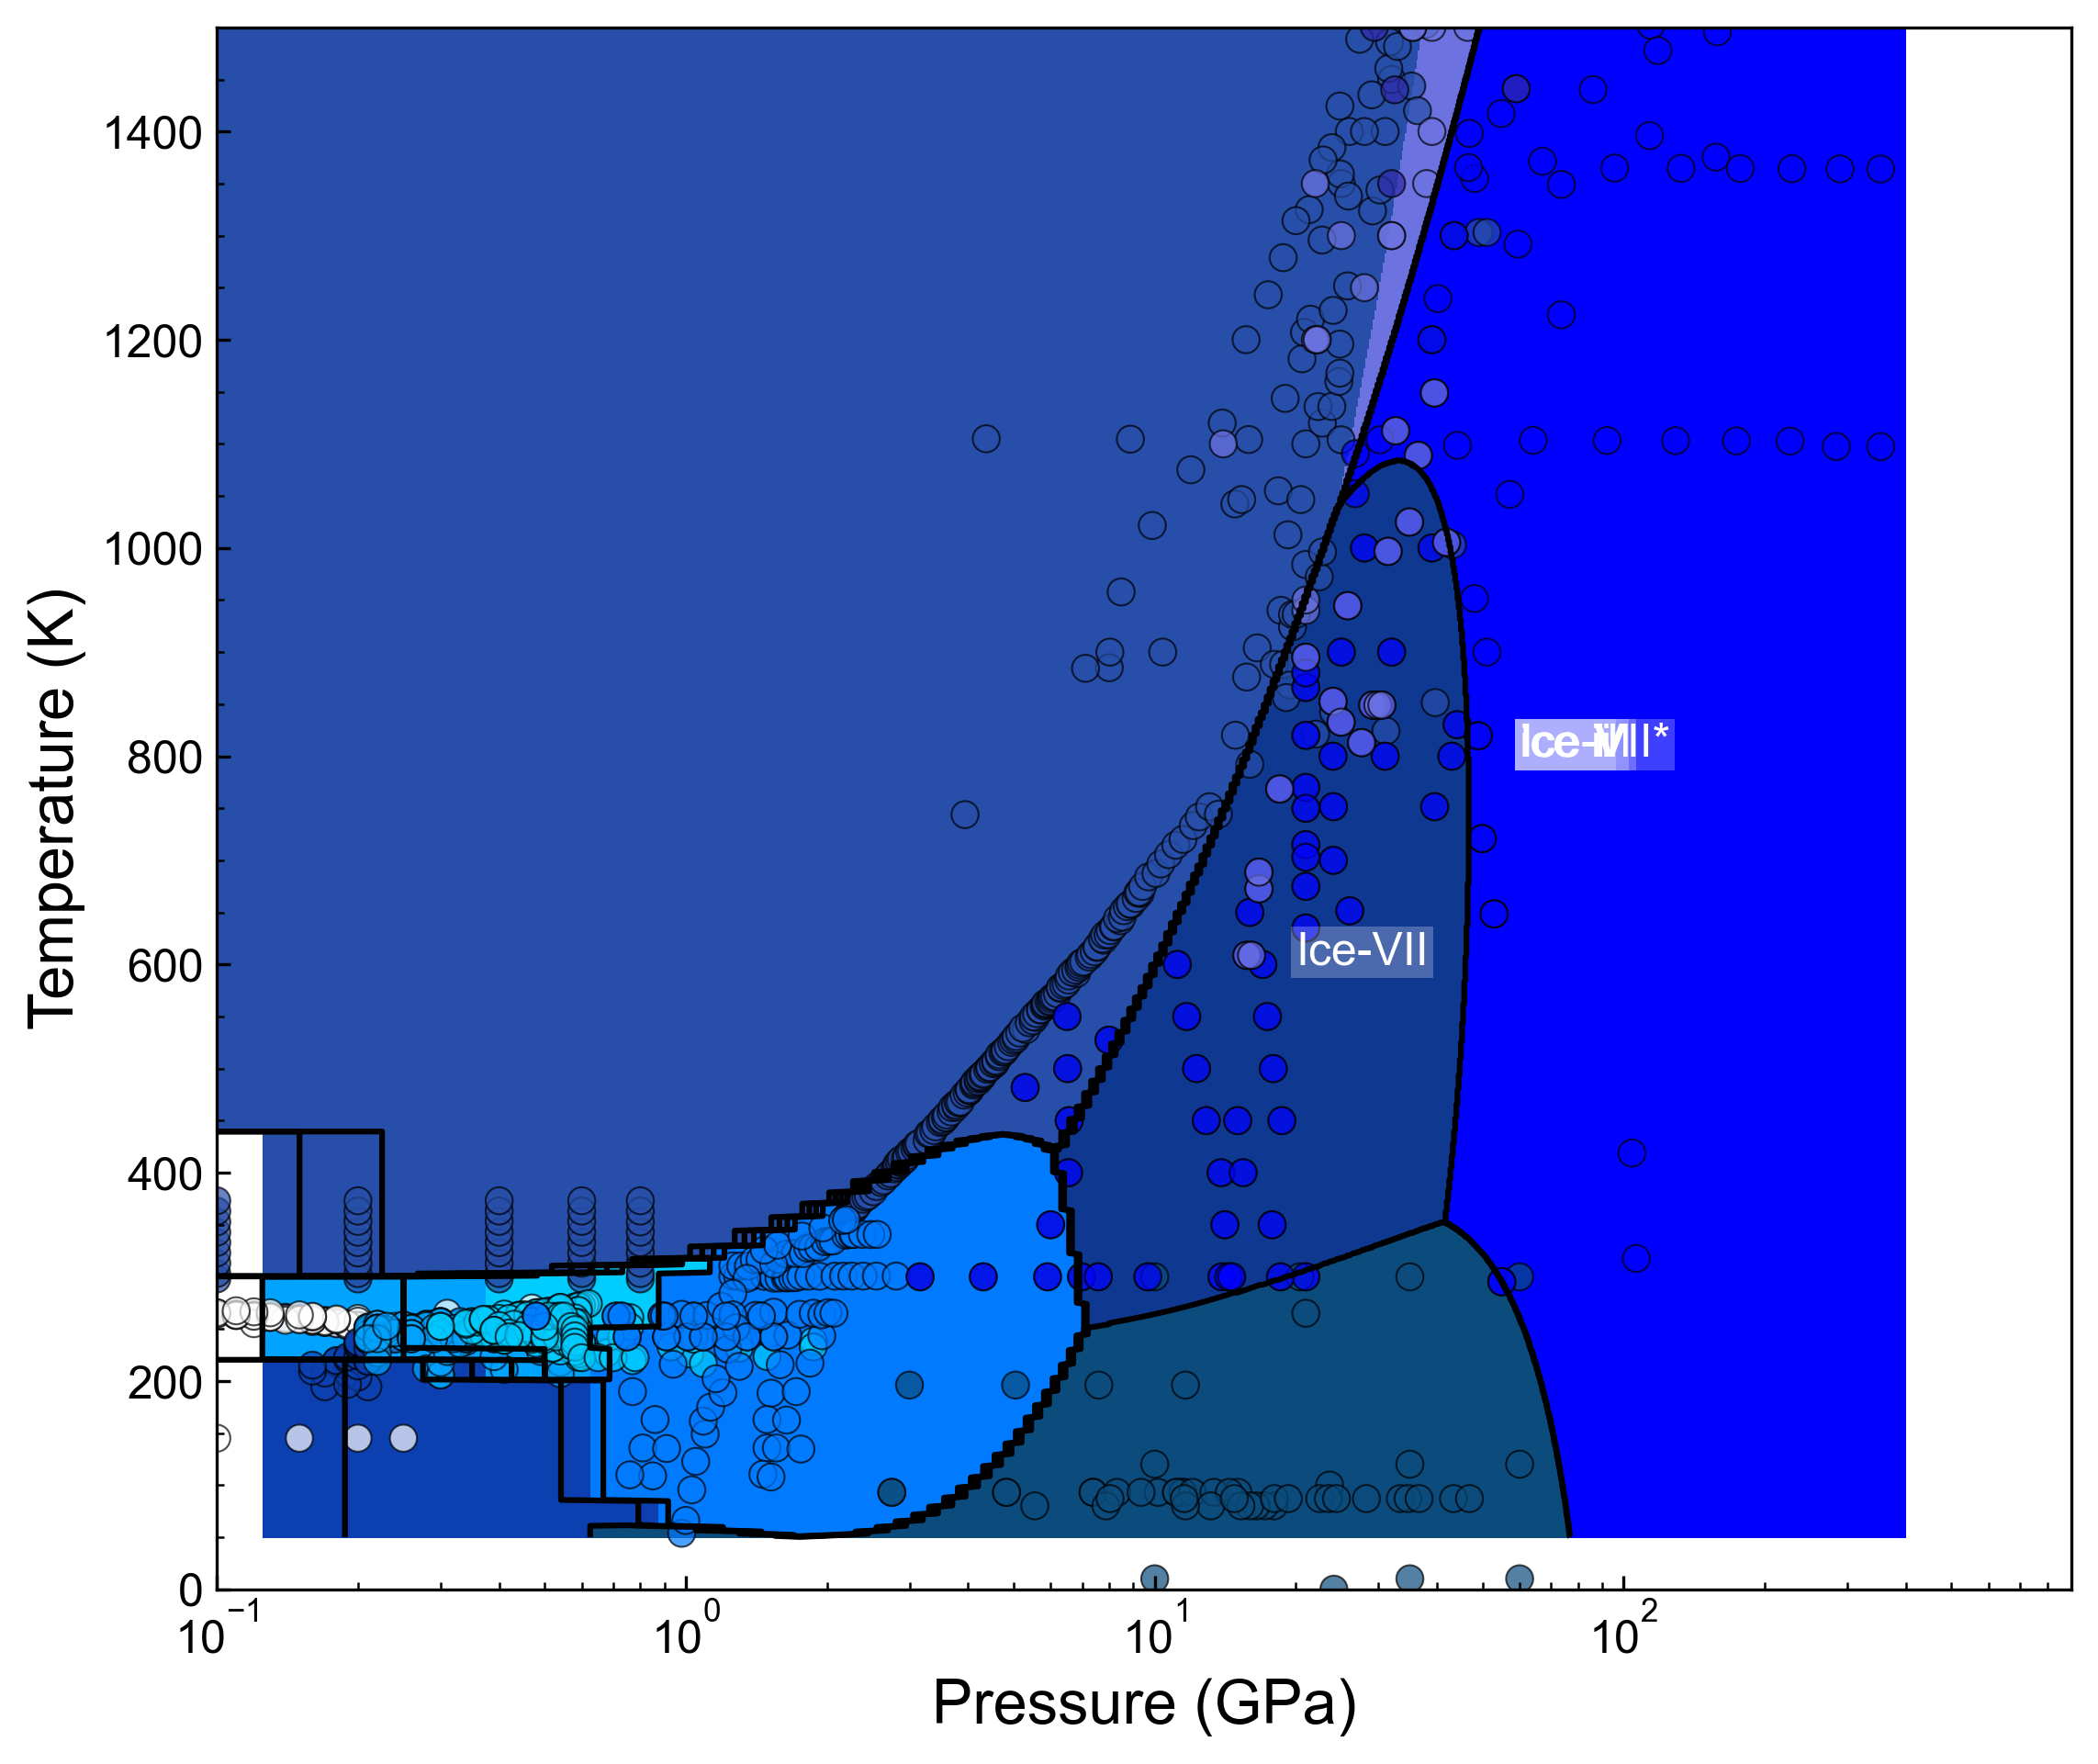

In [395]:
cm_scale = 1/2.54

ms = 50
ms_old = 50
ac_old = 0.6
lw = 0.5
lw_old = 0.8

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(19*cm_scale, 16*cm_scale),dpi=300)
axes = []
gs0 = GridSpec(1,1,bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

axes.append(fig.add_subplot(gs0[0]))

axes[0].pcolormesh(pv, tv, Y_hat.reshape(pv.shape), cmap=phase_colors,alpha = 1)

axes[0].contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1)

axes[0].scatter(data0['P (GPa)'],data0['T (K)'],cmap=phase_colors, c= data0['PhaseLabel'], edgecolors='k', s = ms, lw = lw, marker = 'o', alpha = 0.7)

axes[0].plot(uranus['P (GPa)'],uranus['T (K)'], linestyle = '--', c='k')
axes[0].plot(uranus['P (GPa)'],uranus['T (K)']+400, linestyle = '--', c='k')
#axes[0].plot(neptune['P (GPa)'],neptune['T (K)'], linestyle = ':', c='k')

axes[0].set_xlim([0.1,900])
axes[0].set_ylim([0,1500])
#axes[0].set_yscale('log')
axes[0].set_xscale('log')

#axes[0].set_xlim([0,1000])
#axes[0].set_ylim([0,9000])
axes[0].tick_params(labelsize=12)
axes[0].minorticks_on()
axes[0].tick_params(direction='in')
axes[0].tick_params(direction='in',which="minor")
axes[0].set_xlabel('Pressure (GPa)', fontsize = 16)
axes[0].set_ylabel('Temperature (K)', fontsize = 16)


axes[0].annotate('Fluid', xy=(20, 4500),  xycoords='data',  color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-FCC', xy=(200, 3000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-BCC', xy=(36, 1650),  xycoords='data', color = 'w', fontsize = 12, rotation = 75,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-X', xy=(200, 2000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII', xy=(20, 600),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('ice ii', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII*', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice III', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice V', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))


# axes[0].annotate('Present-day\nUranus', xy=(225, 4450),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',
#                  bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].text(350,5000,r'\textrm{H}$_{2}$O',fontsize=16,ha="center",va="center",color='k',rotation=0#, weight='bold'
#             ,bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 1))    

# axes[0].annotate('Neptune', xy=(112, 3250),  xycoords='data', color = 'k', fontsize = 8 ,
#                  bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].annotate('SI-bcc', (55, 1800),xycoords='data',
#             xytext=(30, 2000), textcoords='data',
#             arrowprops=dict(arrowstyle="->"),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].annotate('ice-VII', (35, 1050),xycoords='data',
#             xytext=(100, 1200), textcoords='data', color = 'w',
#             arrowprops=dict(arrowstyle="->", color ='w'),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].set_xlim([1,10000])
# axes[0].set_ylim([1000,160000])
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
#fig.set_facecolor('none')

fig.savefig('h2o_uranus_flagship_2023.jpg', bbox_inches = "tight")

## Y_hat

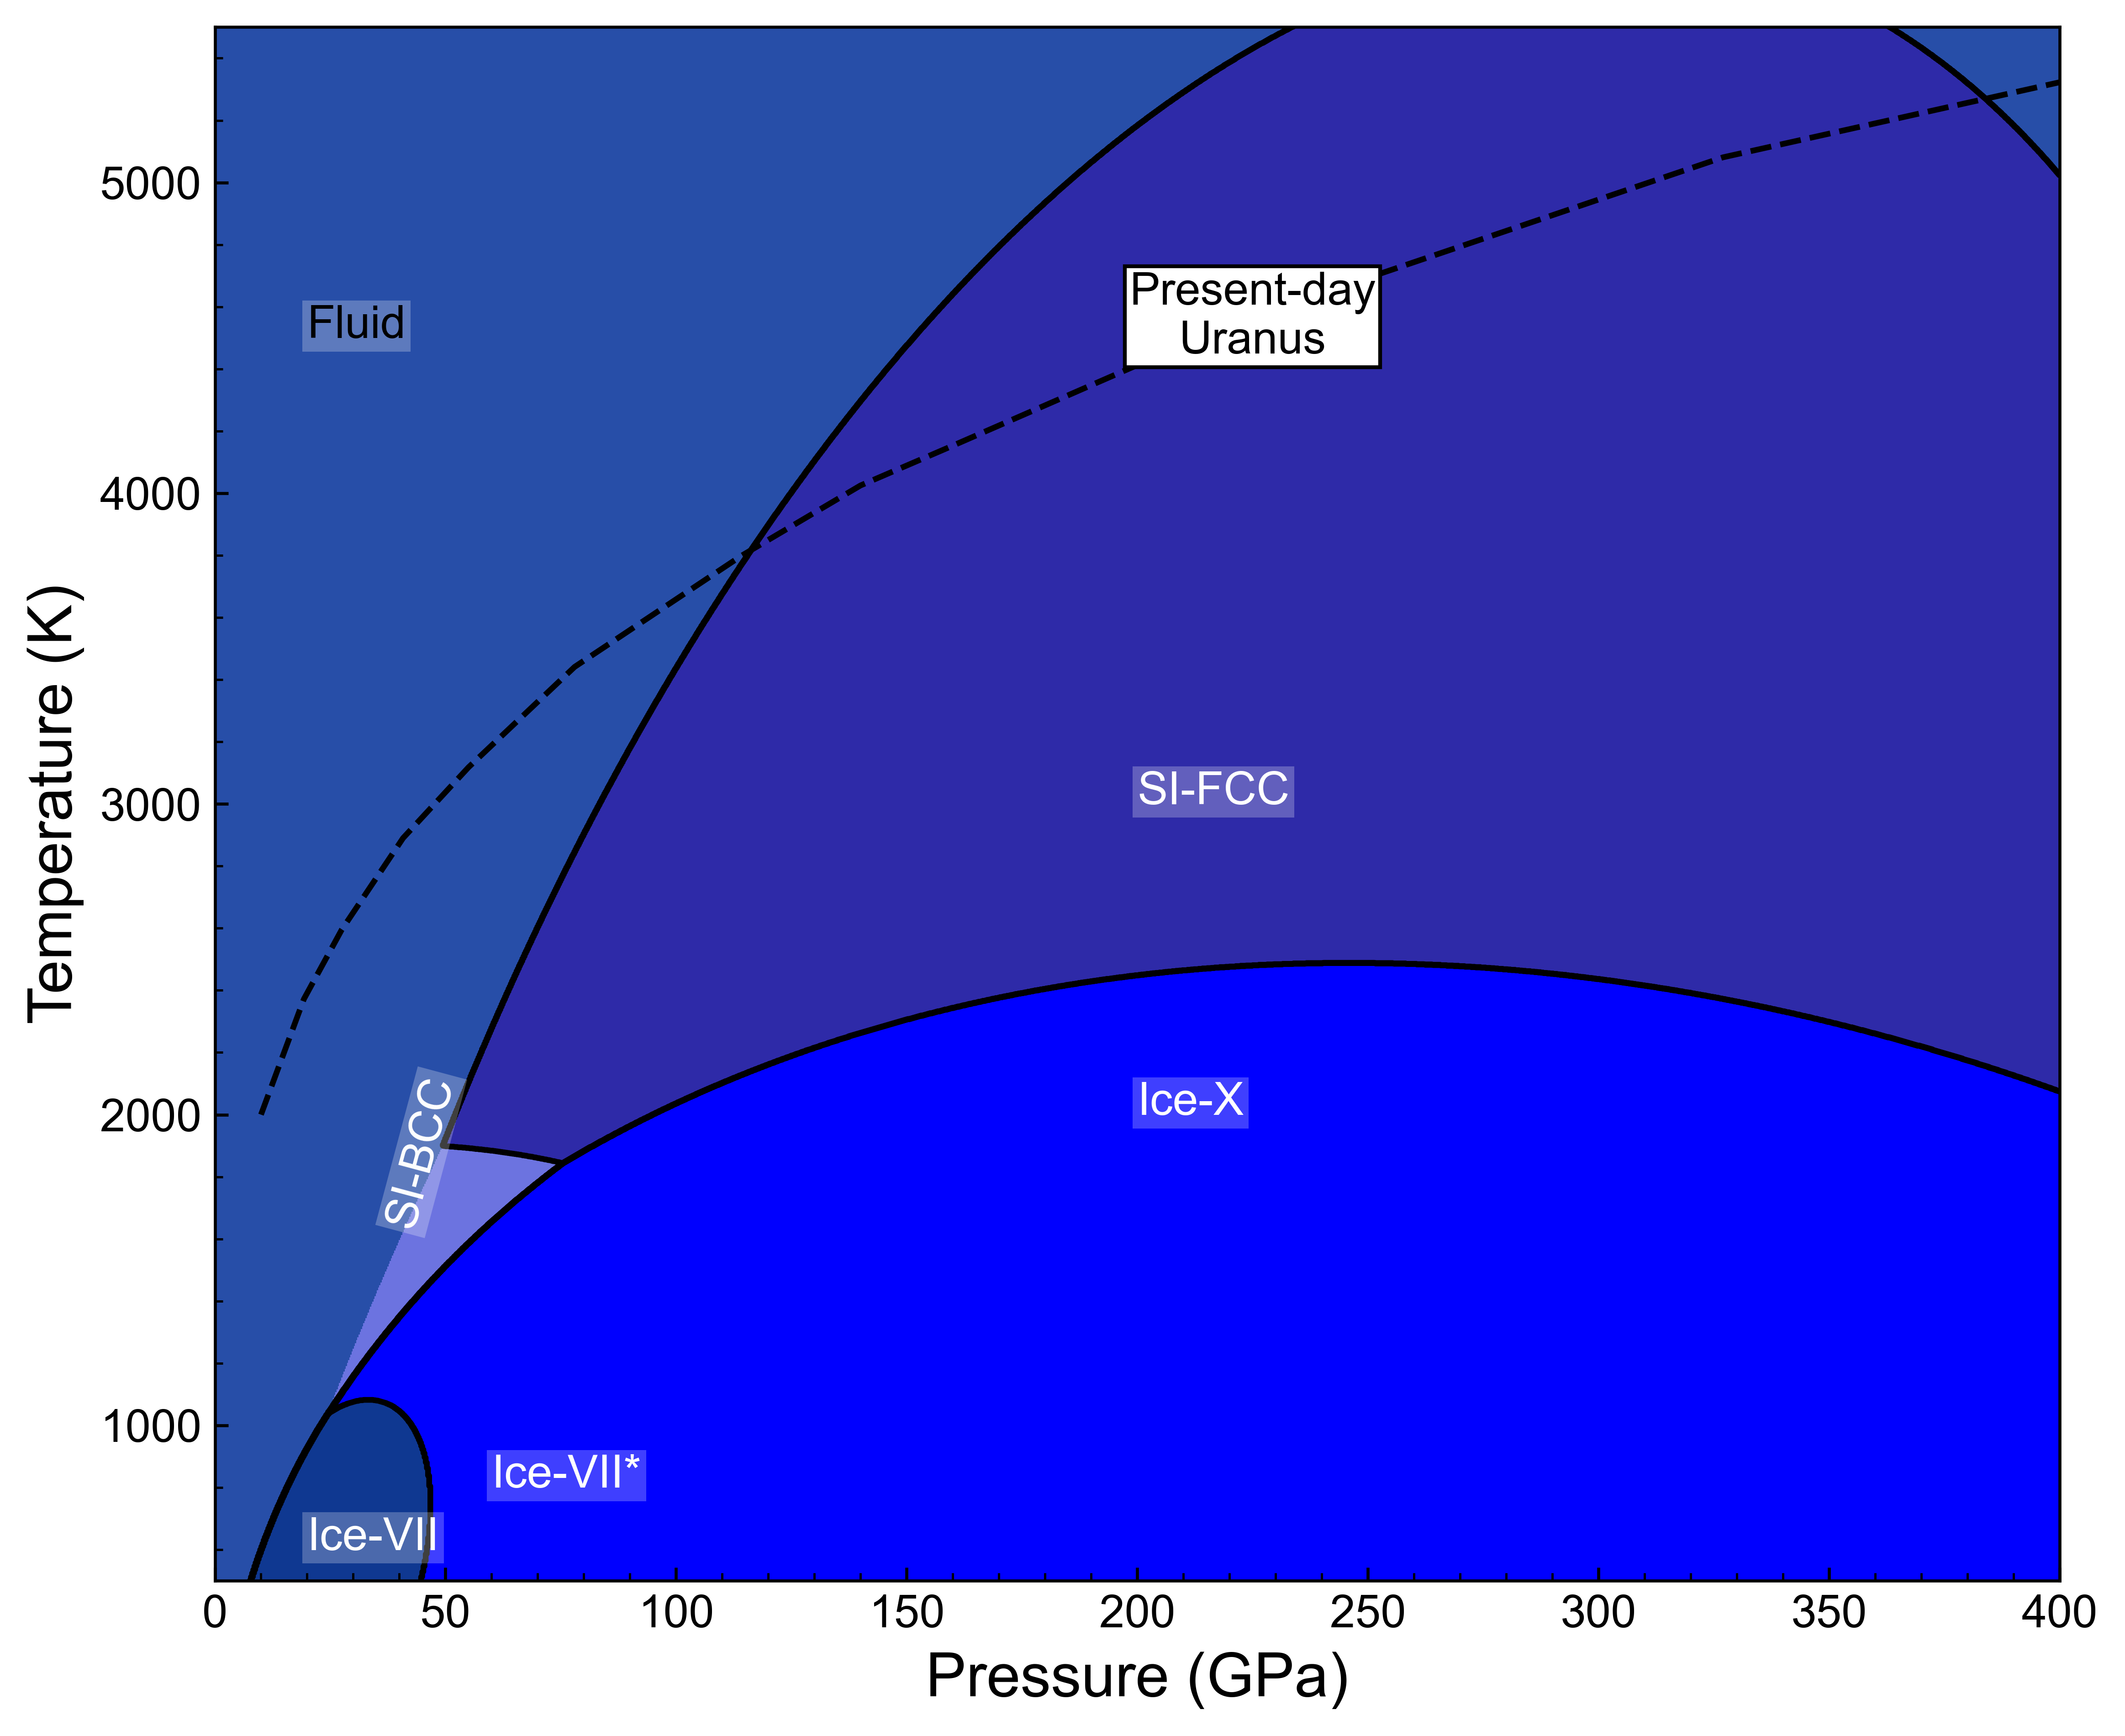

In [319]:
cm_scale = 1/2.54

ms = 50
ms_old = 50
ac_old = 0.6
lw = 0.5
lw_old = 0.8

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(19*cm_scale, 16*cm_scale),dpi=600)
axes = []
gs0 = GridSpec(1,1,bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

axes.append(fig.add_subplot(gs0[0]))

axes[0].pcolormesh(pv, tv, Y_hat.reshape(pv.shape), cmap=phase_colors,alpha = 1)

axes[0].contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1)

#axes[0].scatter(data0['P (GPa)'],data0['T (K)'],cmap=phase_colors, c= data0['PhaseLabel'], edgecolors='k', s = ms, lw = lw, marker = 'o', alpha = 0.7)

axes[0].plot(uranus['P (GPa)'],uranus['T (K)'], linestyle = '--', c='k')
#axes[0].plot(neptune['P (GPa)'],neptune['T (K)'], linestyle = ':', c='k')

# axes[0].set_xlim([10,1000])
# axes[0].set_ylim([900,9000])
# axes[0].set_yscale('log')
# axes[0].set_xscale('log')

axes[0].set_xlim([0,400])
axes[0].set_ylim([500,5500])
axes[0].tick_params(labelsize=12)
axes[0].minorticks_on()
axes[0].tick_params(direction='in')
axes[0].tick_params(direction='in',which="minor")

axes[0].set_xlabel('Pressure (GPa)', fontsize = 16)
axes[0].set_ylabel('Temperature (K)', fontsize = 16)


axes[0].annotate('Fluid', xy=(20, 4500),  xycoords='data',  color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-FCC', xy=(200, 3000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-BCC', xy=(36, 1650),  xycoords='data', color = 'w', fontsize = 12, rotation = 75,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-X', xy=(200, 2000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII', xy=(20, 600),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII*', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))

axes[0].annotate('Present-day\nUranus', xy=(225, 4450),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].text(350,5000,r'\textrm{H}$_{2}$O',fontsize=16,ha="center",va="center",color='k',rotation=0#, weight='bold'
#             ,bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 1))    

# axes[0].annotate('Neptune', xy=(112, 3250),  xycoords='data', color = 'k', fontsize = 8 ,
#                  bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].annotate('SI-bcc', (55, 1800),xycoords='data',
#             xytext=(30, 2000), textcoords='data',
#             arrowprops=dict(arrowstyle="->"),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].annotate('ice-VII', (35, 1050),xycoords='data',
#             xytext=(100, 1200), textcoords='data', color = 'w',
#             arrowprops=dict(arrowstyle="->", color ='w'),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].set_xlim([1,10000])
# axes[0].set_ylim([1000,160000])
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
#fig.set_facecolor('none')
fig.savefig('h2o_uranus_flagship_2023_0.jpg', bbox_inches = "tight")

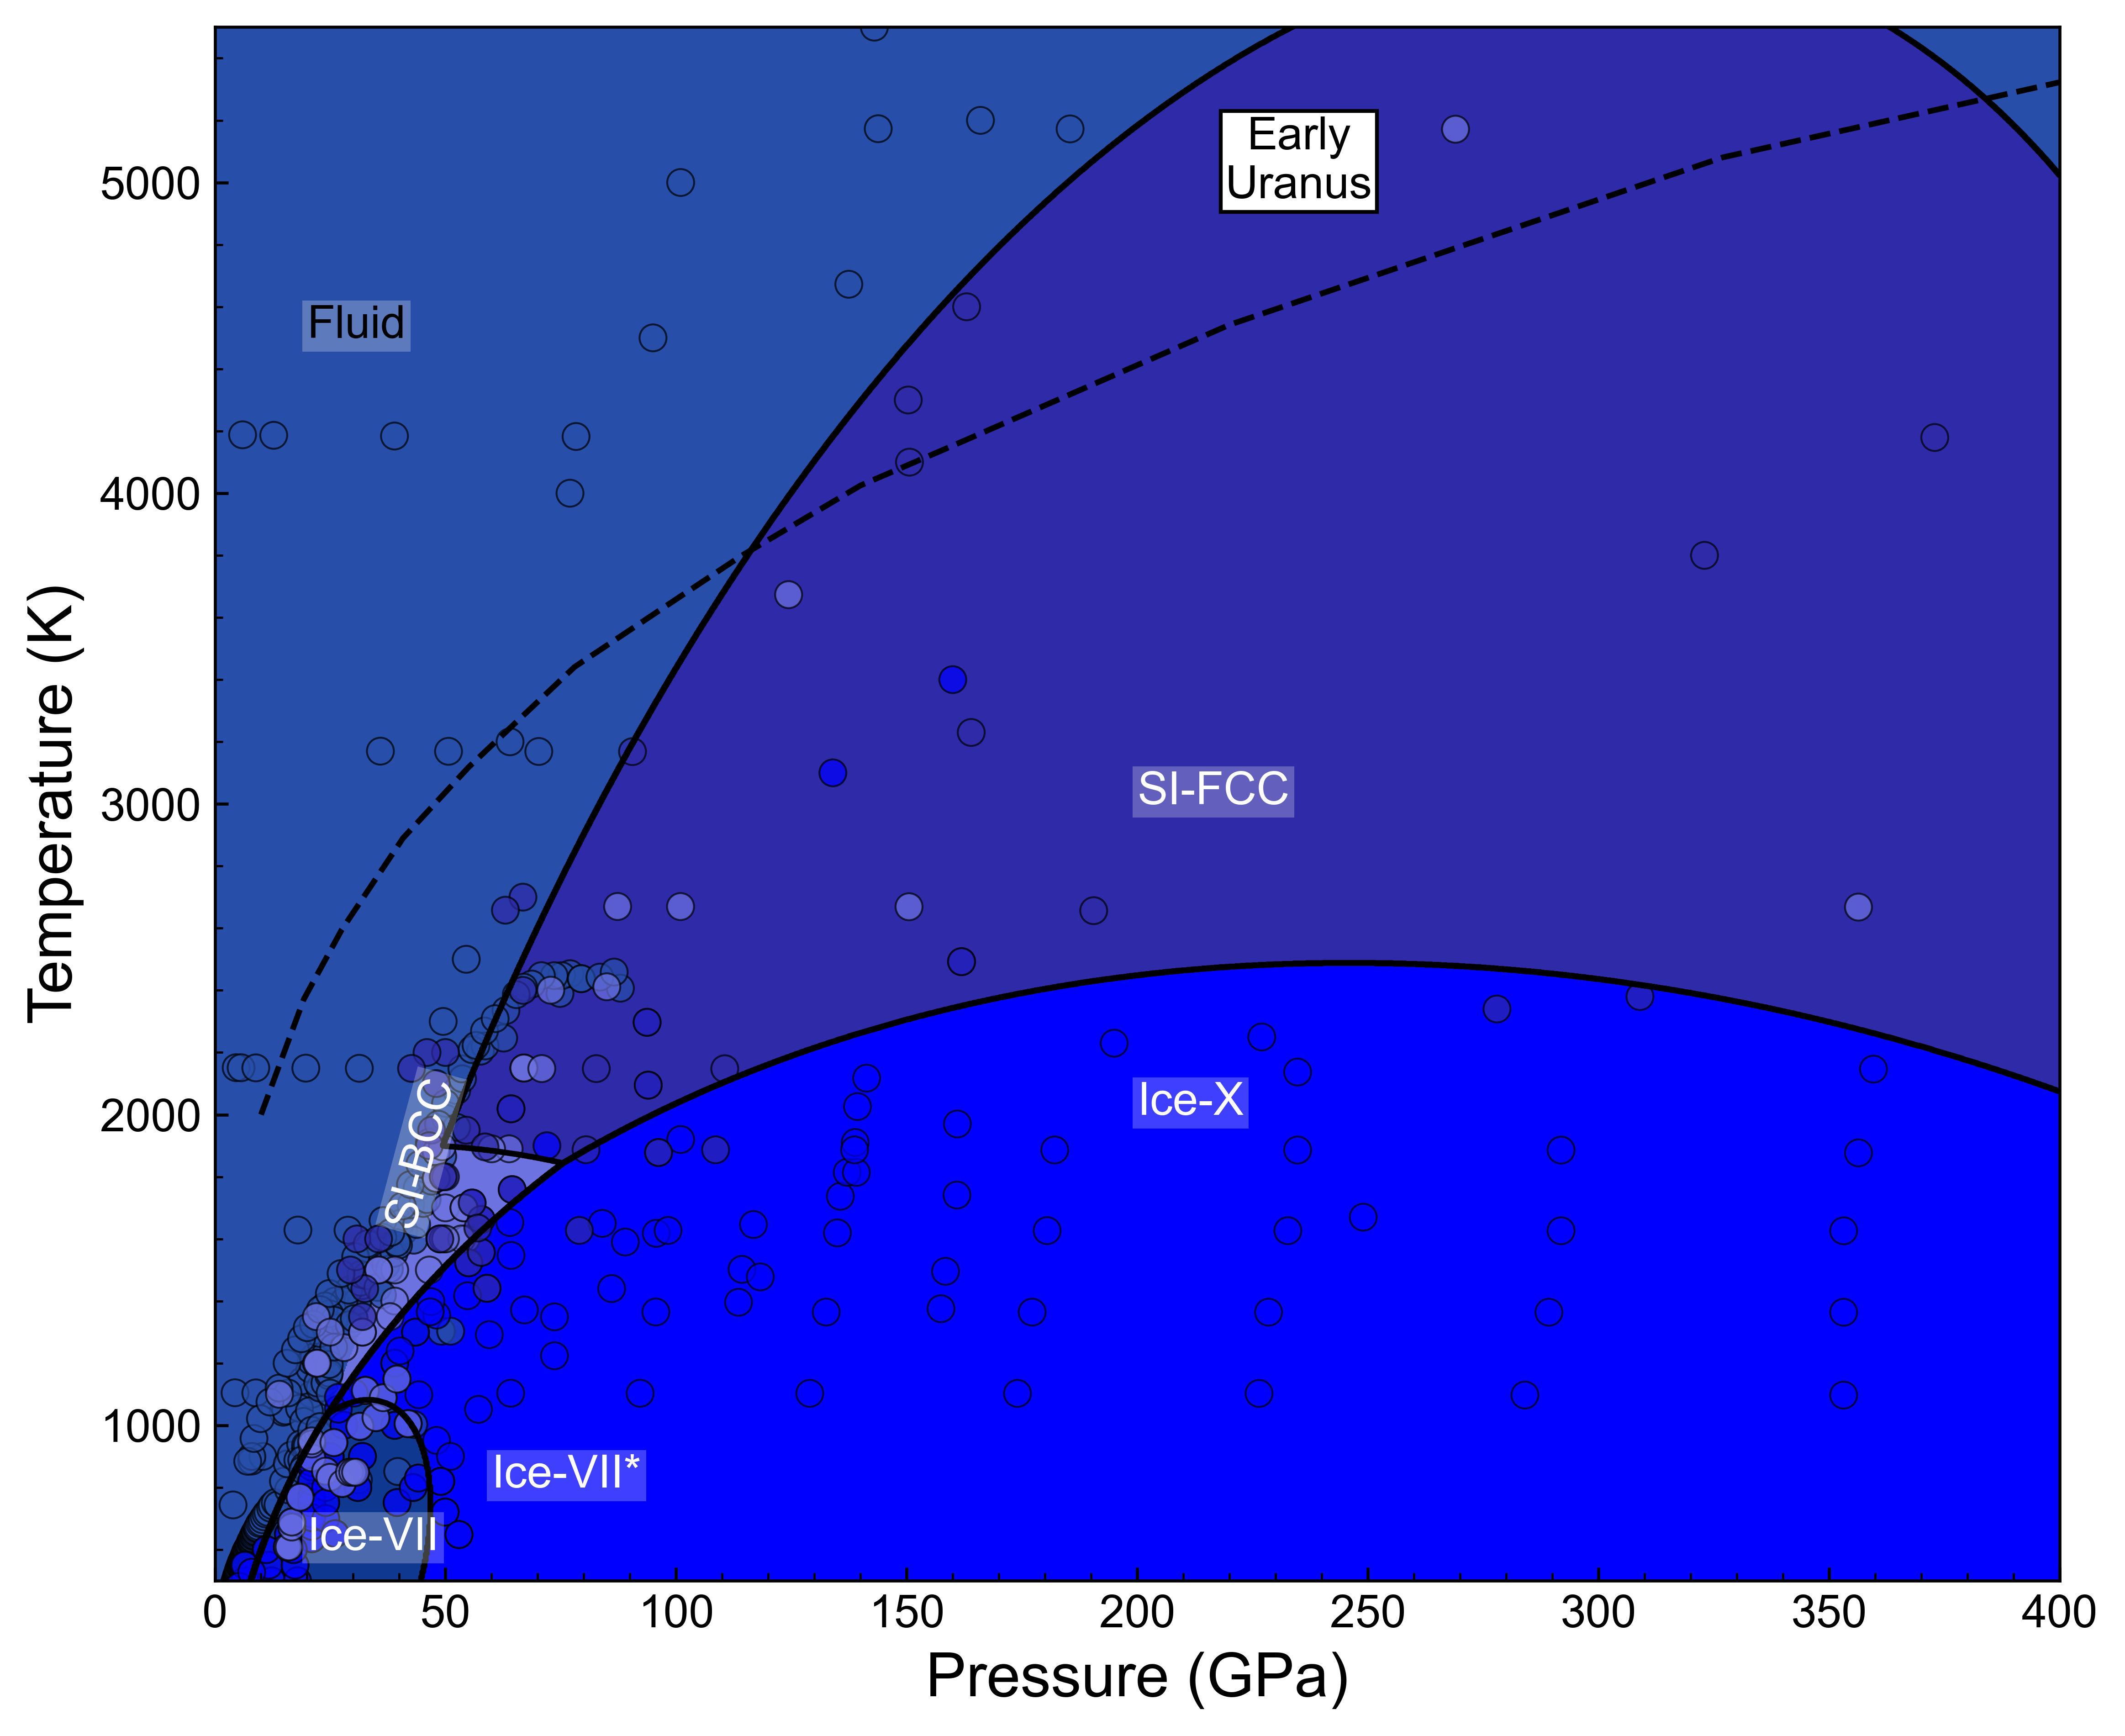

In [320]:
cm_scale = 1/2.54

ms = 50
ms_old = 50
ac_old = 0.6
lw = 0.5
lw_old = 0.8

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(19*cm_scale, 16*cm_scale),dpi=600)
axes = []
gs0 = GridSpec(1,1,bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

axes.append(fig.add_subplot(gs0[0]))

axes[0].pcolormesh(pv, tv, Y_hat.reshape(pv.shape), cmap=phase_colors,alpha = 1)

axes[0].contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1)

axes[0].scatter(data0['P (GPa)'],data0['T (K)'],cmap=phase_colors, c= data0['PhaseLabel'], edgecolors='k', s = ms, lw = lw, marker = 'o', alpha = 0.7)

axes[0].plot(uranus['P (GPa)'],uranus['T (K)'], linestyle = '--', c='k')

#axes[0].plot(uranus['P (GPa)'],uranus['T (K)']+400, linestyle = '--', c='k')
#axes[0].plot(neptune['P (GPa)'],neptune['T (K)'], linestyle = ':', c='k')

# axes[0].set_xlim([10,1000])
# axes[0].set_ylim([900,9000])
# axes[0].set_yscale('log')
# axes[0].set_xscale('log')

axes[0].set_xlim([0,400])
axes[0].set_ylim([500,5500])
axes[0].tick_params(labelsize=12)
axes[0].minorticks_on()
axes[0].tick_params(direction='in')
axes[0].tick_params(direction='in',which="minor")

axes[0].set_xlabel('Pressure (GPa)', fontsize = 16)
axes[0].set_ylabel('Temperature (K)', fontsize = 16)


axes[0].annotate('Fluid', xy=(20, 4500),  xycoords='data',  color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-FCC', xy=(200, 3000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-BCC', xy=(36, 1650),  xycoords='data', color = 'w', fontsize = 12, rotation = 75,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-X', xy=(200, 2000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII', xy=(20, 600),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII*', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))

# axes[0].annotate('Present-day\nUranus', xy=(225, 4450),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',
#                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

axes[0].annotate('Early\nUranus', xy=(235, 4950),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].text(350,5000,r'\textrm{H}$_{2}$O',fontsize=16,ha="center",va="center",color='k',rotation=0#, weight='bold'
#             ,bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 1))    

# axes[0].annotate('Neptune', xy=(112, 3250),  xycoords='data', color = 'k', fontsize = 8 ,
#                  bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].annotate('SI-bcc', (55, 1800),xycoords='data',
#             xytext=(30, 2000), textcoords='data',
#             arrowprops=dict(arrowstyle="->"),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].annotate('ice-VII', (35, 1050),xycoords='data',
#             xytext=(100, 1200), textcoords='data', color = 'w',
#             arrowprops=dict(arrowstyle="->", color ='w'),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].set_xlim([1,10000])
# axes[0].set_ylim([1000,160000])
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
#fig.set_facecolor('none')
fig.savefig('h2o_uranus_flagship_2023_1.jpg', bbox_inches = "tight")

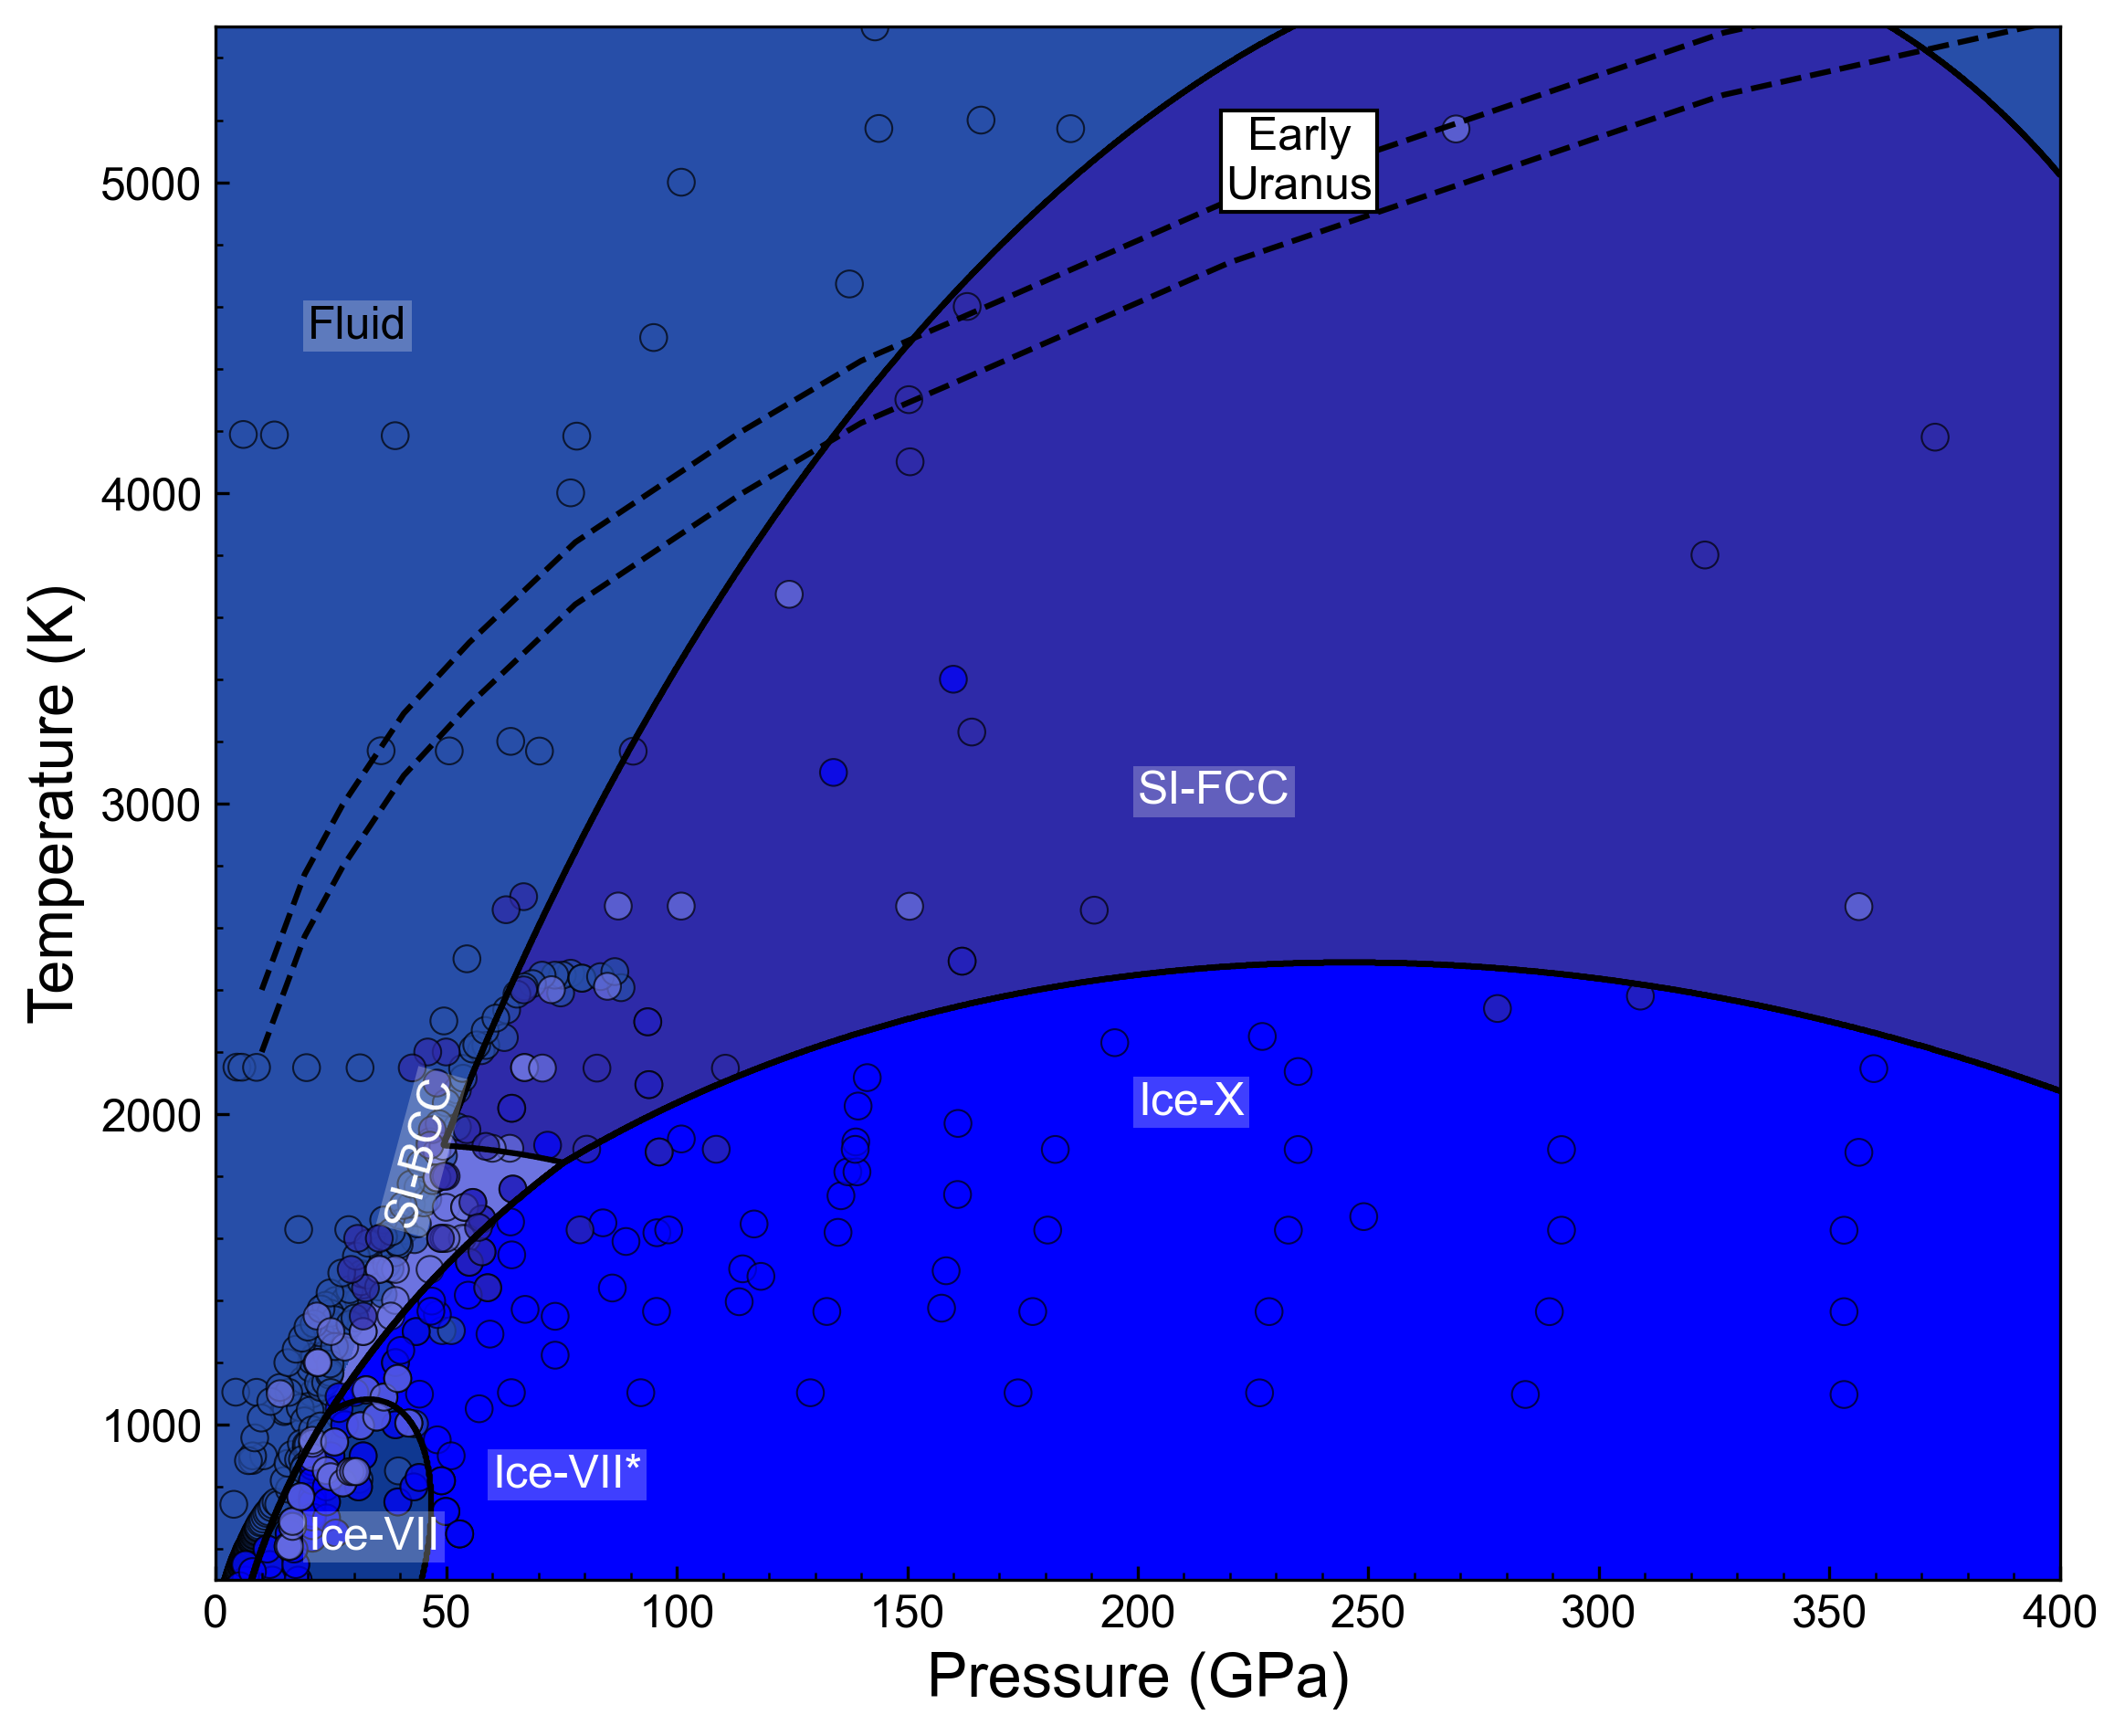

In [321]:
cm_scale = 1/2.54

ms = 50
ms_old = 50
ac_old = 0.6
lw = 0.5
lw_old = 0.8

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(19*cm_scale, 16*cm_scale),dpi=300)
axes = []
gs0 = GridSpec(1,1,bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

axes.append(fig.add_subplot(gs0[0]))

axes[0].pcolormesh(pv, tv, Y_hat.reshape(pv.shape), cmap=phase_colors,alpha = 1)

axes[0].contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1)

axes[0].scatter(data0['P (GPa)'],data0['T (K)'],cmap=phase_colors, c= data0['PhaseLabel'], edgecolors='k', s = ms, lw = lw, marker = 'o', alpha = 0.7)

axes[0].plot(uranus['P (GPa)'],uranus['T (K)']+200, linestyle = '--', c='k')

axes[0].plot(uranus['P (GPa)'],uranus['T (K)']+400, linestyle = '--', c='k')
#axes[0].plot(neptune['P (GPa)'],neptune['T (K)'], linestyle = ':', c='k')

# axes[0].set_xlim([10,1000])
# axes[0].set_ylim([900,9000])
# axes[0].set_yscale('log')
# axes[0].set_xscale('log')

axes[0].set_xlim([0,400])
axes[0].set_ylim([500,5500])
axes[0].tick_params(labelsize=12)
axes[0].minorticks_on()
axes[0].tick_params(direction='in')
axes[0].tick_params(direction='in',which="minor")

axes[0].set_xlabel('Pressure (GPa)', fontsize = 16)
axes[0].set_ylabel('Temperature (K)', fontsize = 16)


axes[0].annotate('Fluid', xy=(20, 4500),  xycoords='data',  color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-FCC', xy=(200, 3000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('SI-BCC', xy=(36, 1650),  xycoords='data', color = 'w', fontsize = 12, rotation = 75,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-X', xy=(200, 2000),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII', xy=(20, 600),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))
axes[0].annotate('Ice-VII*', xy=(60, 800),  xycoords='data', color = 'w', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 0.25))

# axes[0].annotate('Present-day\nUranus', xy=(225, 4450),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',
#                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

axes[0].annotate('Early\nUranus', xy=(235, 4950),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].text(350,5000,r'\textrm{H}$_{2}$O',fontsize=16,ha="center",va="center",color='k',rotation=0#, weight='bold'
#             ,bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 1))    

# axes[0].annotate('Neptune', xy=(112, 3250),  xycoords='data', color = 'k', fontsize = 8 ,
#                  bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].annotate('SI-bcc', (55, 1800),xycoords='data',
#             xytext=(30, 2000), textcoords='data',
#             arrowprops=dict(arrowstyle="->"),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].annotate('ice-VII', (35, 1050),xycoords='data',
#             xytext=(100, 1200), textcoords='data', color = 'w',
#             arrowprops=dict(arrowstyle="->", color ='w'),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].set_xlim([1,10000])
# axes[0].set_ylim([1000,160000])
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
#fig.set_facecolor('none')
fig.savefig('h2o_uranus_flagship_2023_2.jpg', bbox_inches = "tight")

### bootstrap

In [324]:
import pickle
import tracemalloc

In [325]:
# pv, tv = np.meshgrid(np.linspace(0, 1000, 1000,endpoint=True), np.linspace(500, 6000, 550,endpoint=True))

In [399]:
pb_data = data0

In [401]:
# Y_hat_boot = {}
# Y_hat_proba_boot = {}
# models = {}
# modelfits = {}
degree = 2
num = 100
p_range =np.array([0, 400])
t_range =np.array([500, 6000])


for i in tqdm(range(0,num)):
    # starting the monitoring
    tracemalloc.start()
    data_resampled = pb_data.sample(frac =  0.63, replace=True)
    X_resampled_poly = PolynomialFeatures(degree=degree,include_bias=False).fit_transform(data_resampled[['P (GPa)','T (K)']])
    Y_resampled = data_resampled['PhaseLabel']
    models = LogisticRegression(C = 10, class_weight = 'balanced', multi_class = 'ovr', penalty = 'l1', solver = 'liblinear')
    modelfits = models.fit(X_resampled_poly, Y_resampled)
    pv_boot, tv_boot = np.meshgrid(np.arange(p_range[0], p_range[1], 0.5), np.arange(t_range[0], t_range[1], 10))
    X_resampled_pred = np.c_[pv_boot.ravel(), tv_boot.ravel()]
    X_resampled_pred_poly = PolynomialFeatures(degree=degree,include_bias=False).fit_transform(X_resampled_pred)
    Y_hat_boot = modelfits.predict(X_resampled_pred_poly) #Y_resampled_hat
    Y_hat_proba_boot  = modelfits.predict_proba(X_resampled_pred_poly) #Y_resampled_hat

    # Store data (serialize)
    with open(('/Volumes/PEGASUS/mlpd-bootstraps/h2o/Y_hat_' + str(i) +'.pickle'), 'wb') as f:
        pickle.dump(Y_hat_boot, f)
    # with open(('/Volumes/DONG-SSD/H_MTZ/results/bootstrap_Y_hat_proba_boot_' + str(i) +'.pickle'), 'wb') as f:
    #     pickle.dump(Y_hat_proba_boot, f)
    del data_resampled 
    del X_resampled_poly 
    del Y_resampled 
    del models
    del modelfits
    # del pv_boot
    # del tv_boot
    del X_resampled_pred 
    del X_resampled_pred_poly 
    del Y_hat_boot 
    del Y_hat_proba_boot 

    # displaying the memory
    # print(tracemalloc.get_traced_memory()/(1024*1024))

    # current, peak = tracemalloc.get_traced_memory()
    # current_memories.append(current/(1024*1024))
    # peak_memories.append(peak/(1024*1024))
    # tracemalloc.reset_peak()
    # # tracemalloc.clear_traces()
    # del current, peak
    # print('Average current memory [MB]: {}, average peak memory [MB]: {} +/- {}'.format(
    #   round(np.mean(current_memories), 4), round(np.mean(peak_memories), 4), 
    #   round(np.std(peak_memories), 4))
    #   )
# del Y_hat_boot
# del Y_hat_proba_boot

  0%|                                                   | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/PEGASUS/mlpd-bootstraps/h2o/Y_hat_0.pickle'

In [ ]:
Y_hat_boot = {}
# Y_hat_proba_boot = {}

num_0 = 0
num_1 = 100

for i in tqdm(range(num_0,num_1)):
    #print(('/Volumes/PEGASUS/mlpd-bootstraps/h2o/bootstrap_Y_hat_boot_' + str(i) +'.pickle'))
    # Y_hat_boot[i]  = modelfits[i].predict(X_resampled_pred_poly) #Y_resampled_hat
    # Y_hat_proba_boot[i]  = modelfits[i].predict_proba(X_resampled_pred_poly) #Y_resampled_hat
    try:
        with open(('/Volumes/PEGASUS/mlpd-bootstraps/h2o/Y_hat_' + str(i) +'.pickle'), 'rb') as f:
            Y_hat_boot[i] = pickle.load(f)
    except (pickle.UnpicklingError, FileNotFoundError) as e:
        print("Error loading pickled file:", str(e))

        #print(dict)
    # with open(('/Volumes/DONG-SSD/H_MTZ/results/bootstrap_Y_hat_proba_boot_' + str(i) +'.pickle'), 'rb') as f:
    #     Y_hat_proba_boot[i] = pickle.load(f)
    #     #print(dict)


In [ ]:
num_0 = 0
num_1 = 100
p_range =np.array([0, 400])
t_range =np.array([500, 6000])
pv_boot, tv_boot = np.meshgrid(np.arange(p_range[0], p_range[1], 0.5), np.arange(t_range[0], t_range[1], 10))

In [ ]:
t_select = np.arange(500,6000,10)

In [ ]:
pd_wd = {}
pd_rw = {}
pd_bdg = {}
pd_wd_x, pd_wd_y = {},{}
pd_rw_x, pd_rw_y = {},{}

In [406]:
dfs_wd = {}

In [408]:
#pd_wd_y[i].astype(int)

NameError: name 'num_0' is not defined

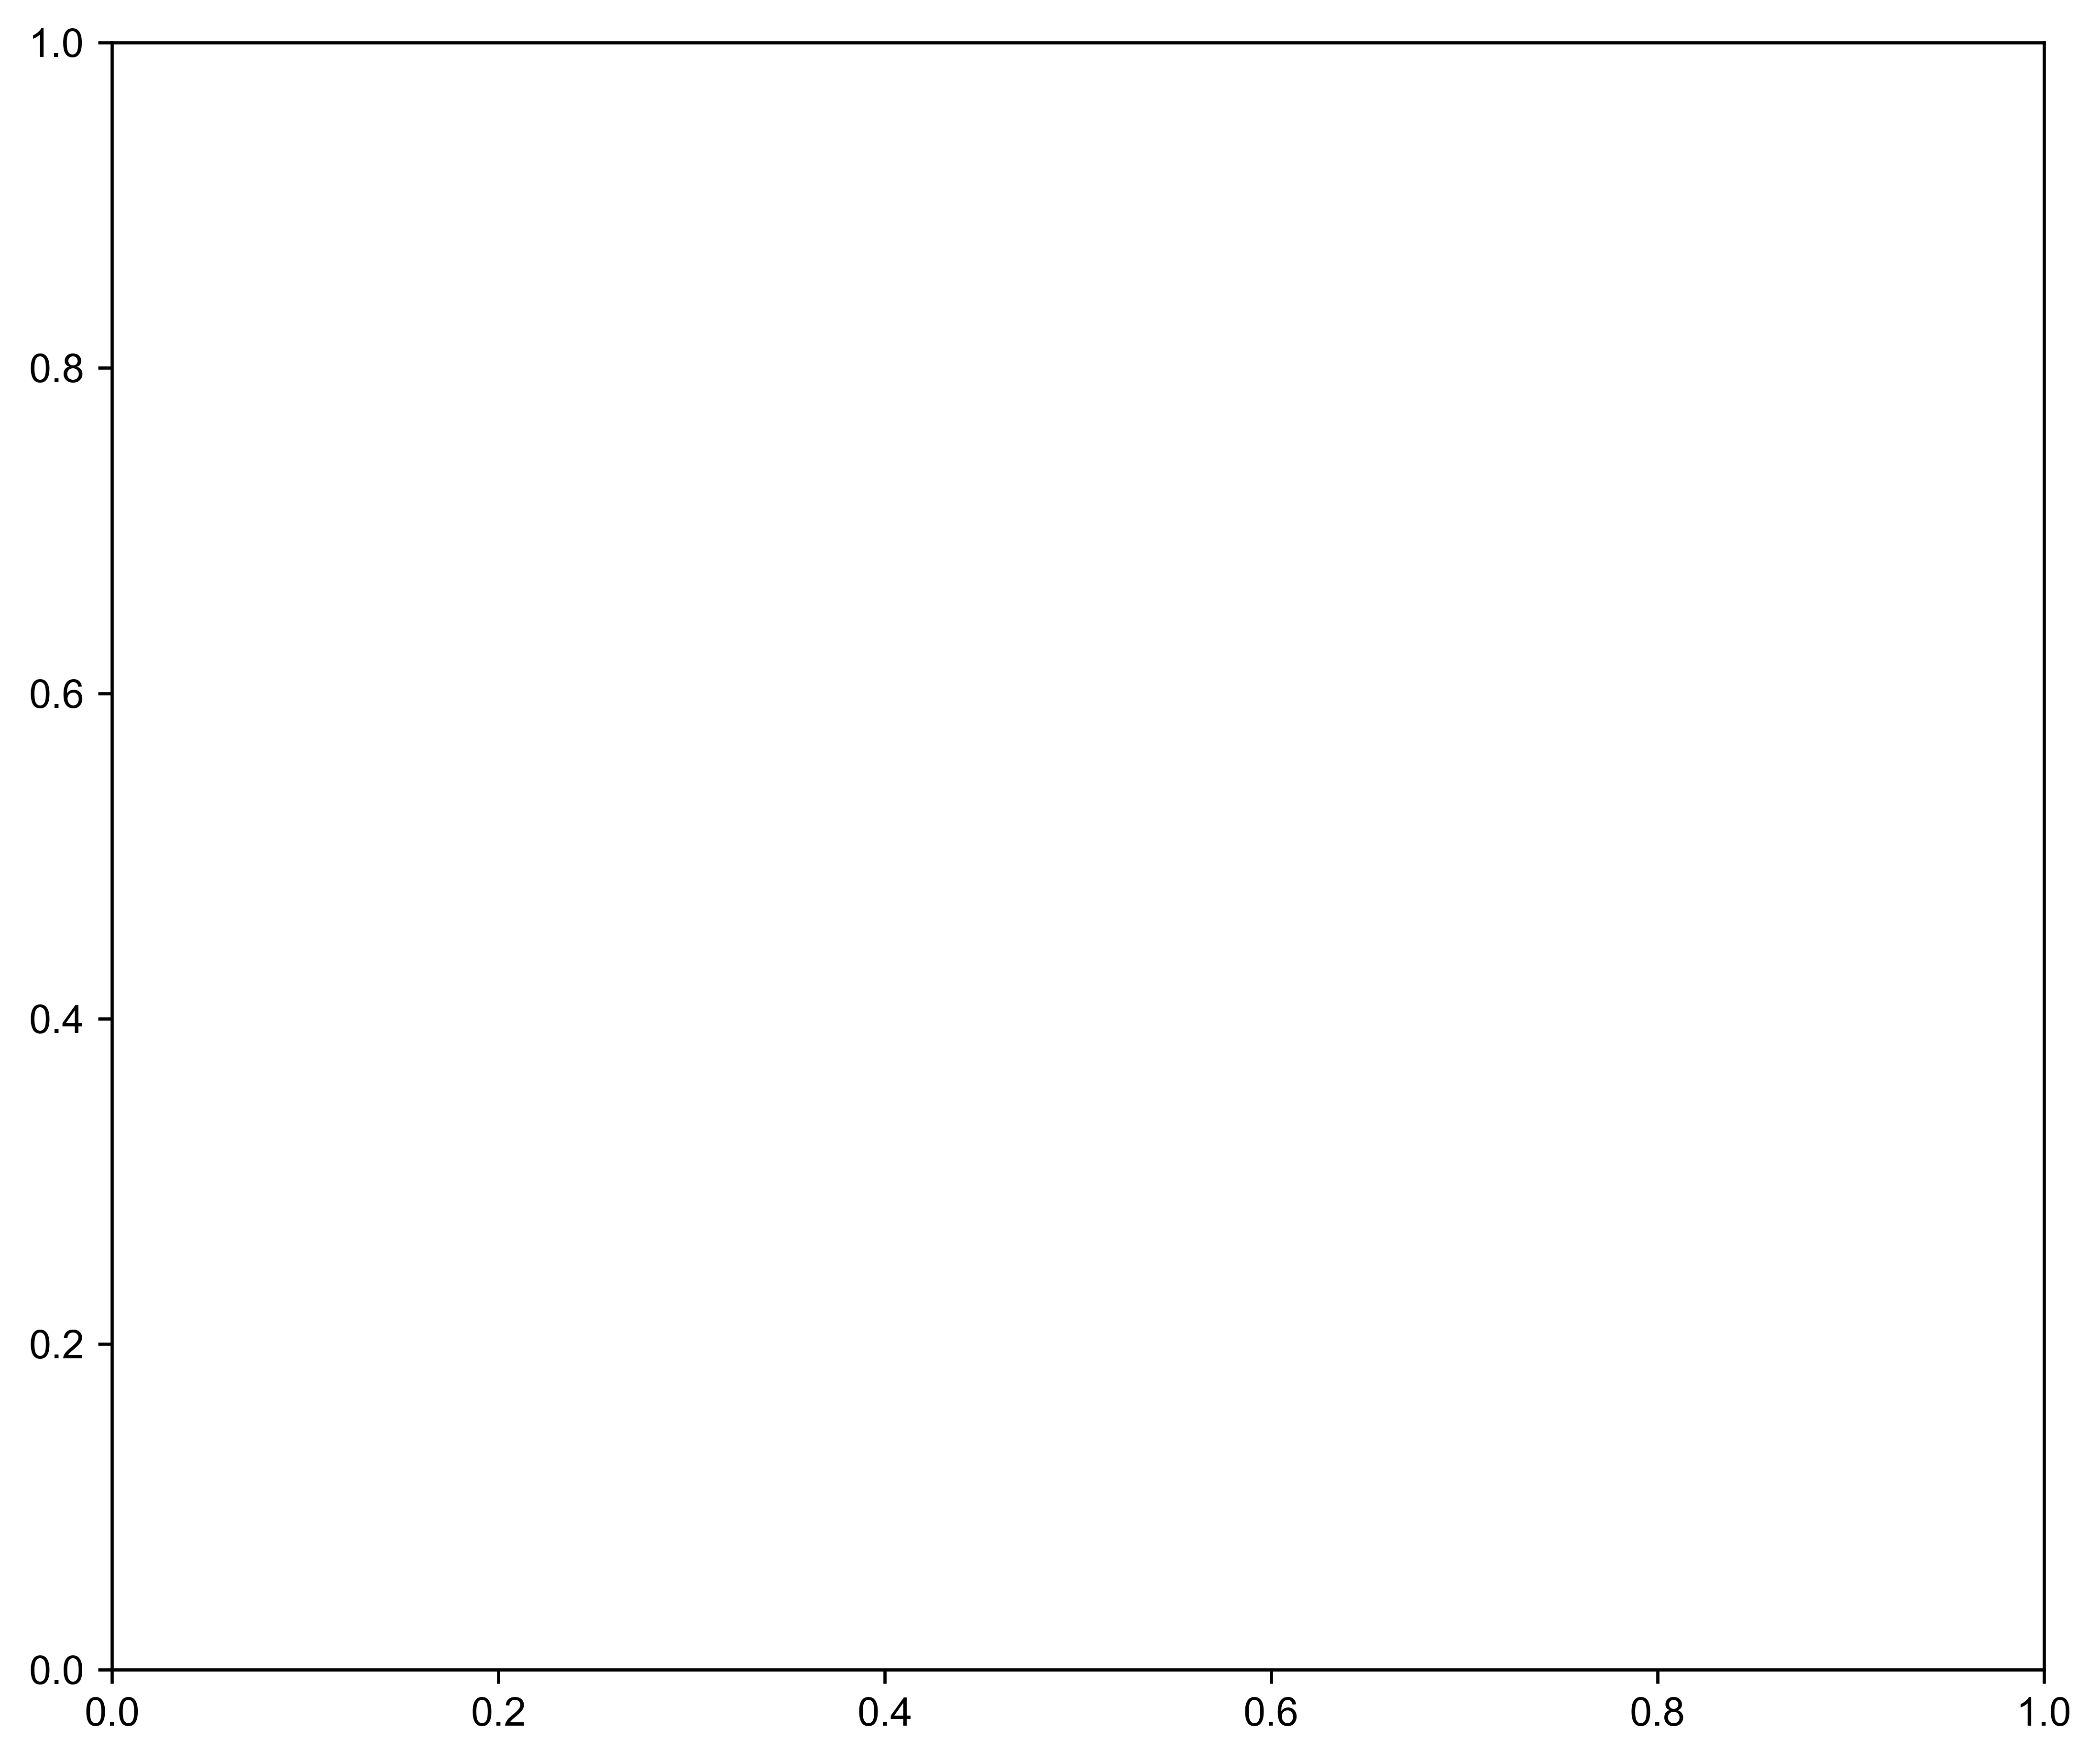

In [410]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(19*cm_scale, 16*cm_scale),dpi=600)
axes = []
gs0 = GridSpec(1,1,bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

axes.append(fig.add_subplot(gs0[0]))

for i in tqdm(range(num_0,num_1)):
    cs = plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[0.000001,1,2,3,4], colors = 'lightgrey',alpha = 0.01, linestyles = '-')
    p = cs.collections[0].get_paths()[0]
    v = p.vertices
    pd_wd_x[i] = v[:,0]
    pd_wd_y[i] = v[:,1]
    pd_wd[i] = np.c_[pd_wd_y[i],pd_wd_x[i]]
    data = {'pres':pd_wd_x[i]}
    dfs_wd[i] = pd.DataFrame(data, index =pd_wd_y[i].astype(int))
plt.contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1)
plt.scatter(data0['P (GPa)'],data0['T (K)'],cmap=phase_colors, c= data0['PhaseLabel'], edgecolors='k', s = ms, lw = lw, marker = 'o', alpha = 1)
plt.xlim([0,400])
plt.ylim([500,5500])
fig.savefig('h2o_uranus_flagship_2023_boots.jpg', bbox_inches = "tight")

In [ ]:
data0['PhaseLabel'].unique()

In [ ]:
data0['Phase'].unique()

In [414]:
list(le.classes_)

['Ice III',
 'Ice V',
 'Ice VI',
 'Ice-Ih',
 'bcc',
 'ice ii',
 'ice-VII',
 'ice-VIII',
 'liquid',
 'superionic-bcc',
 'superionic-fcc']

In [415]:
newcolors = np.array(['#00A3FF',
                      '#00CCFF',
                      '#007AFF',
                      'w',
                      '#0052FF',
                      '#0000FF'
                      
])
phase_colors_dict_1={0:'#00CCFF',1:'#007AFF',2:'w',3:'#0052FF',4:'#0000FF'}
phase_markers_dict={0:'v',1:'s',2:'o',3:'^',4:'p'}

In [418]:

for i, phase in enumerate(data0['PhaseLabel'].unique()):
    plt.scatter(data0[data0['PhaseLabel']==phase]['P (GPa)'],data0[data0['PhaseLabel']==phase]['T (K)'],c= phase_colors_dict_1[phase], marker =phase_markers_dict[phase], edgecolors='k', s = ms, lw = lw, alpha = 0.75, zorder=10)

KeyError: 6

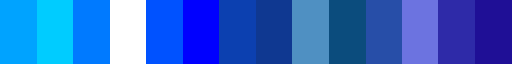

In [420]:
phase_colors

In [422]:
phase_colors_dict_1={0:'#00CCFF',1:'#007AFF',2:'w',3:'#0052FF',4:'#0000FF'}
phase_markers_dict={0:'v',1:'s',2:'o',3:'^',4:'p'}
list(le.classes_)

['Ice III',
 'Ice V',
 'Ice VI',
 'Ice-Ih',
 'bcc',
 'ice ii',
 'ice-VII',
 'ice-VIII',
 'liquid',
 'superionic-bcc',
 'superionic-fcc']

In [424]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='s', color = 'w', markeredgecolor='k', label='Ice-VII',
                          markerfacecolor='#007AFF', markersize=10),
                    Line2D([0], [0], marker='v', color = 'w',markeredgecolor='k', label='Ice-X',
                          markerfacecolor='#00CCFF', markersize=10),
                    Line2D([0], [0], marker='^', color = 'w',markeredgecolor='k', label='SI-BCC',
                          markerfacecolor='#0052FF', markersize=10),
                    Line2D([0], [0], marker='p', color = 'w',markeredgecolor='k', label='SI-FCC',
                        markerfacecolor='#0000FF', markersize=10),
                    Line2D([0], [0], marker='o', color = 'w',markeredgecolor='k', label='Fluid',
                        markerfacecolor='w', markersize=10),
                  Line2D([0], [0], color = 'k', label='ML'),
                  Line2D([0], [0], color = 'lightgrey', label='Bootstrap')]


NameError: name 'num_0' is not defined

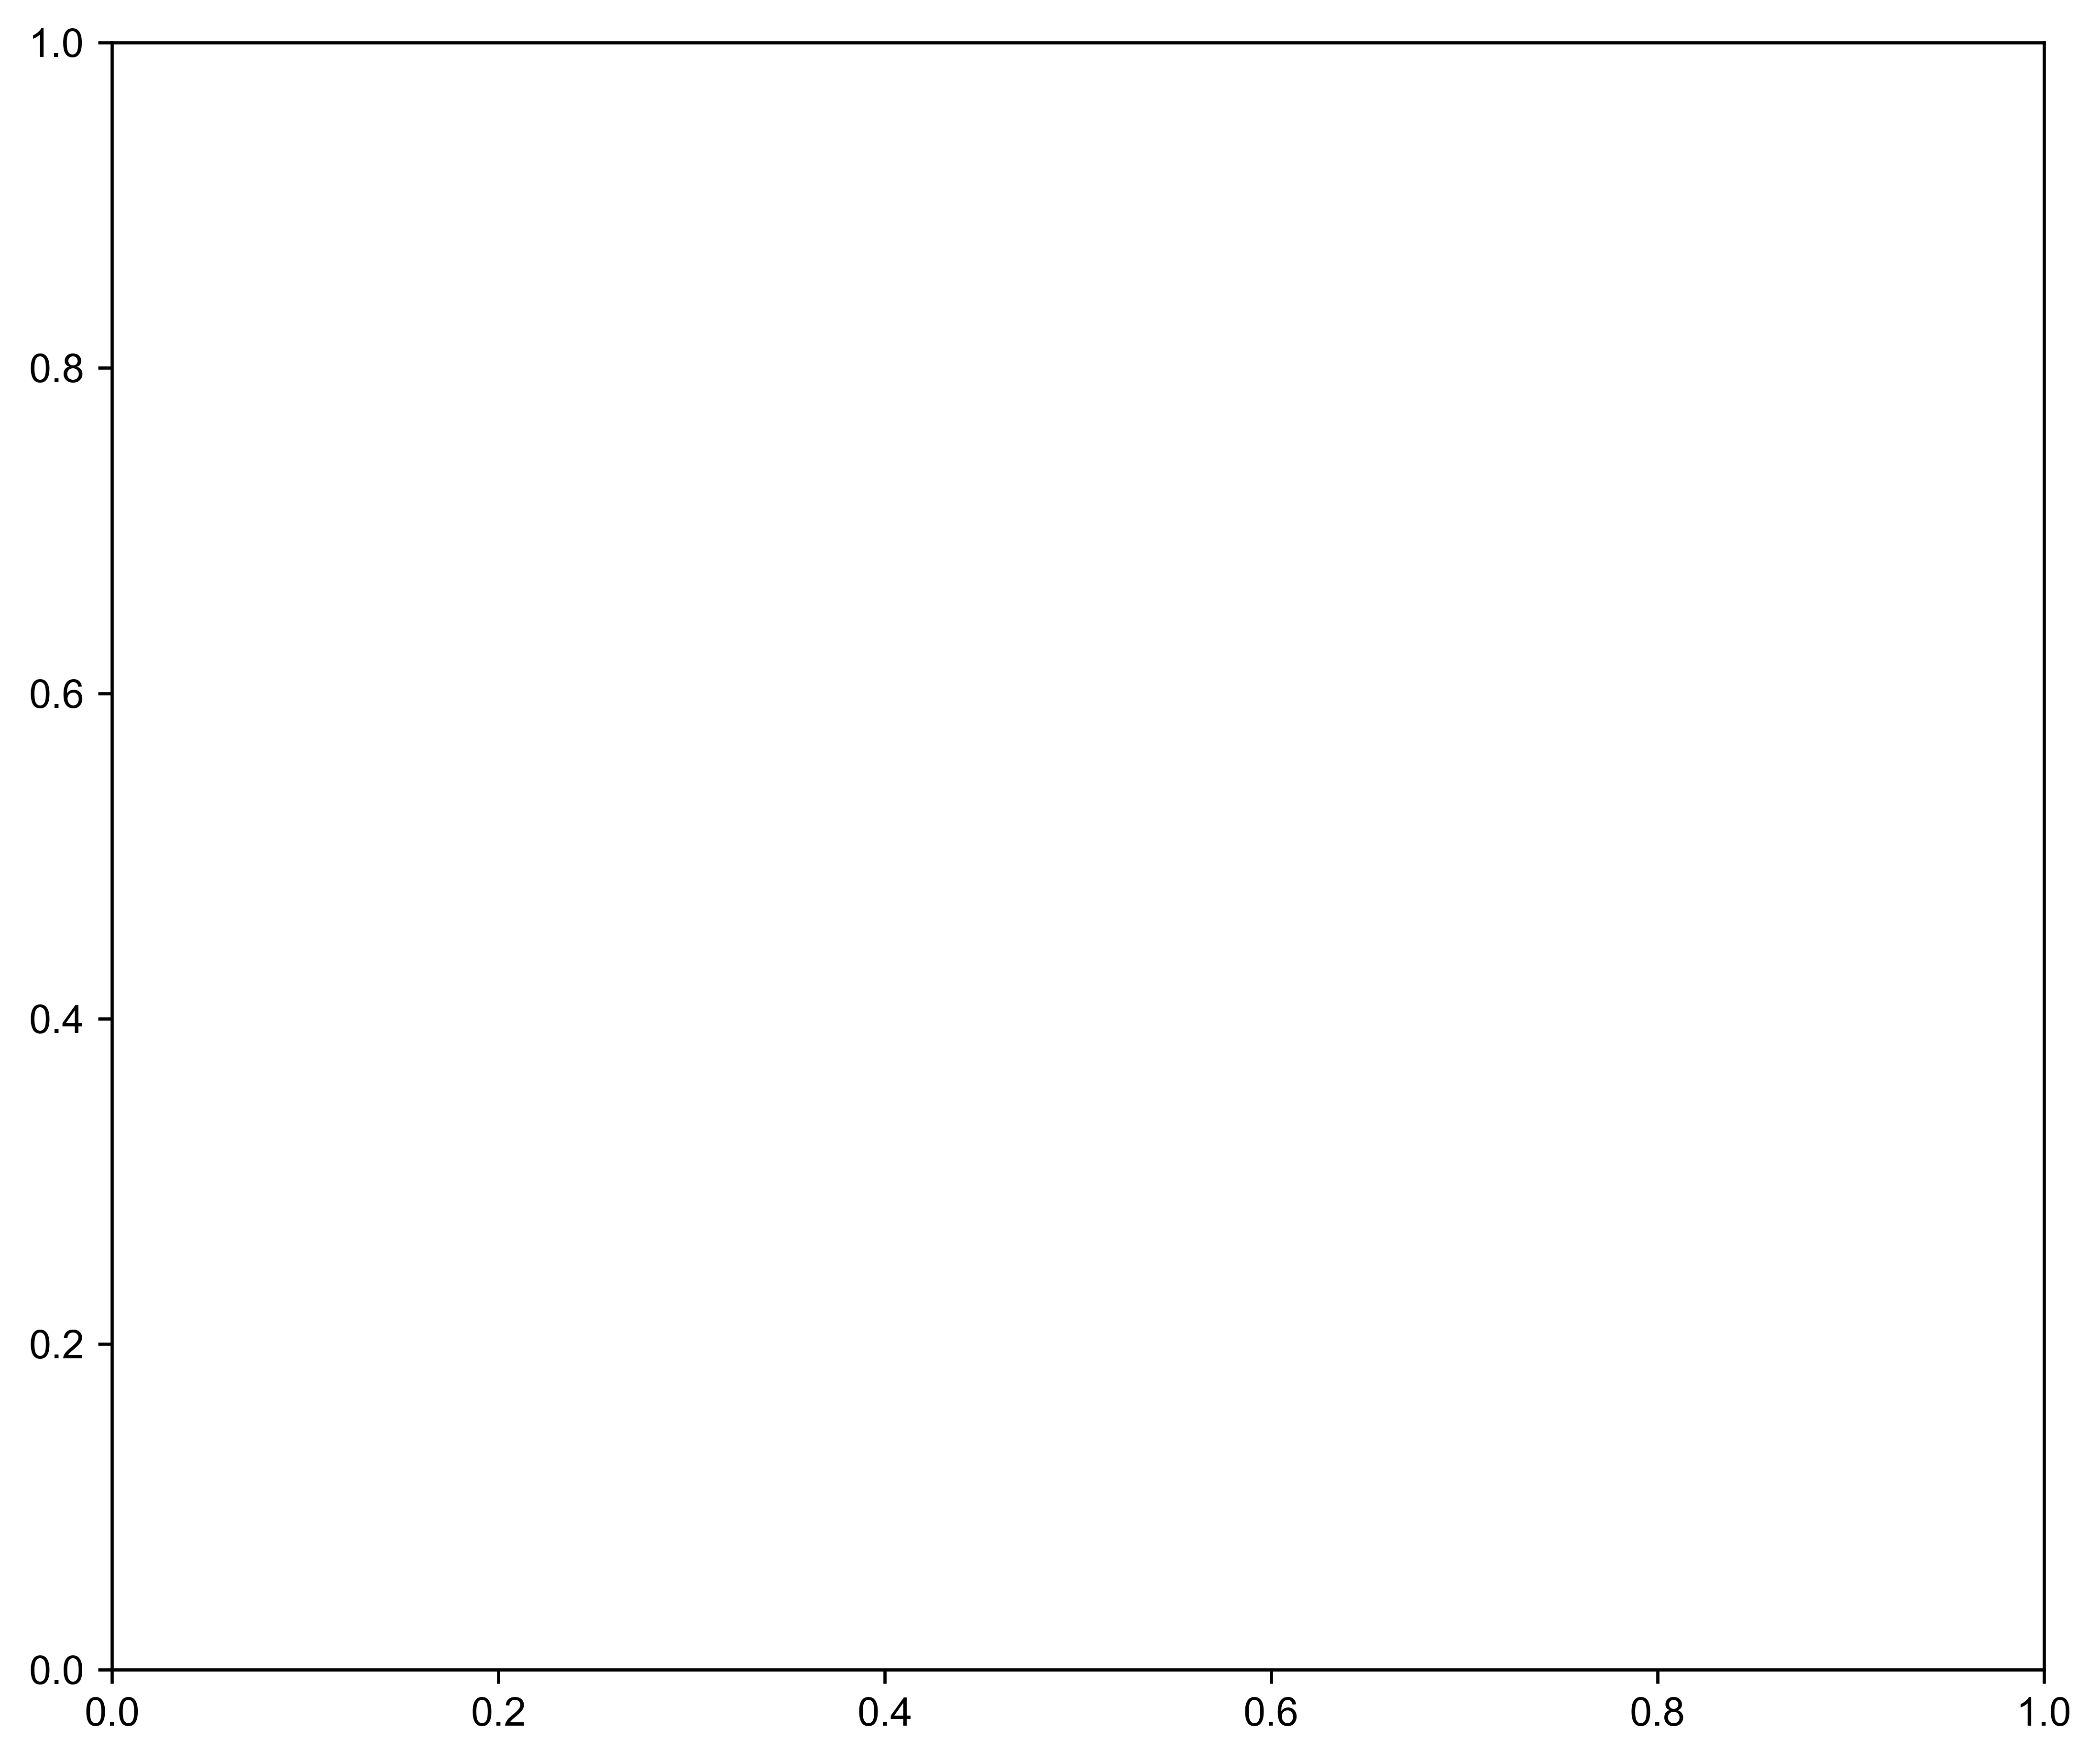

In [426]:
cm_scale = 1/2.54

ms = 50
ms_old = 50
ac_old = 0.6
lw = 0.5
lw_old = 0.8

from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(19*cm_scale, 16*cm_scale),dpi=600)
axes = []
gs0 = GridSpec(1,1,bottom=0.05, top=0.95, left=0.05, right=0.95, hspace=0.05, wspace=0.3)

axes.append(fig.add_subplot(gs0[0]))

# axes[0].pcolormesh(pv, tv, Y_hat.reshape(pv.shape), cmap=phase_colors,alpha = 1)

for i in tqdm(range(num_0,num_1)):
    axes[0].contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[0.000001,1,2,3,4], colors = 'lightgrey',alpha = 0.01, linestyles = '-')

axes[0].contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1, zorder=12)

for i, phase in enumerate(data0['PhaseLabel'].unique()):
    axes[0].scatter(data0[data0['PhaseLabel']==phase]['P (GPa)'],data0[data0['PhaseLabel']==phase]['T (K)'],c= phase_colors_dict_1[phase], marker =phase_markers_dict[phase], edgecolors='k', s = ms, lw = lw, alpha = 0.75, zorder=10)

axes[0].plot(uranus['P (GPa)'],uranus['T (K)'], linestyle = '--', c='k', zorder=10)
# axes[0].plot(uranus['P (GPa)'],uranus['T (K)']+400, linestyle = '--', c='k')
#axes[0].plot(neptune['P (GPa)'],neptune['T (K)'], linestyle = ':', c='k')

# axes[0].set_xlim([10,1000])
# axes[0].set_ylim([900,9000])
# axes[0].set_yscale('log')
# axes[0].set_xscale('log')

axes[0].set_xlim([0,400])
axes[0].set_ylim([500,5500])
axes[0].tick_params(labelsize=12)
axes[0].minorticks_on()
axes[0].tick_params(direction='in')
axes[0].tick_params(direction='in',which="minor")

axes[0].set_xlabel('Pressure (GPa)', fontsize = 16)
axes[0].set_ylabel('Temperature (K)', fontsize = 16)


axes[0].annotate('Fluid', xy=(20, 3900),  xycoords='data',  color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="lightgrey", lw=1, alpha = 0.5))
axes[0].annotate('SI-FCC', xy=(200, 3000),  xycoords='data', color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="lightgrey", lw=1, alpha = 0.5))
axes[0].annotate('SI-BCC', xy=(5, 1850),  xycoords='data', color = 'k', fontsize = 12, zorder=10,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="lightgrey", lw=1, alpha = 0.5))
axes[0].annotate('Ice-X', xy=(200, 2000),  xycoords='data', color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="lightgrey", lw=1, alpha = 0.5))
axes[0].annotate('Ice-VII', xy=(20, 600),  xycoords='data', color = 'k', fontsize = 12, zorder=10,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="lightgrey", lw=1, alpha = 0.5))
axes[0].annotate('Ice-VII*', xy=(60, 800),  xycoords='data', color = 'k', fontsize = 12,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="lightgrey", lw=1, alpha = 0.5))

axes[0].annotate('Present-day\nUranus', xy=(225, 4550),  xycoords='data', color = 'k', fontsize = 12 , ha ='center',rotation=17,
                 bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1), zorder = 12)

# axes[0].text(350,5000,r'\textrm{H}$_{2}$O',fontsize=16,ha="center",va="center",color='k',rotation=0#, weight='bold'
#             ,bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="none", lw=1, alpha = 1))    

# axes[0].annotate('Neptune', xy=(112, 3250),  xycoords='data', color = 'k', fontsize = 8 ,
#                  bbox=dict(boxstyle="square,pad=0.1", fc='w', ec="k", lw=1, alpha = 1))

# axes[0].annotate('SI-bcc', (55, 1800),xycoords='data',
#             xytext=(30, 2000), textcoords='data',
#             arrowprops=dict(arrowstyle="->"),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].annotate('ice-VII', (35, 1050),xycoords='data',
#             xytext=(100, 1200), textcoords='data', color = 'w',
#             arrowprops=dict(arrowstyle="->", color ='w'),
#             horizontalalignment='right', verticalalignment='top')

# axes[0].set_xlim([1,10000])
# axes[0].set_ylim([1000,160000])
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)
#fig.set_facecolor('none')

axes[0].legend(handles=legend_elements, loc='upper left')
fig.savefig('h2o_uranus_flagship_2023.png', bbox_inches = "tight")

In [ ]:
plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[0.000001], colors = 'k',alpha = 0.1, linestyles = '-')

In [ ]:
plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[1], colors = 'k',alpha = 0.1, linestyles = '-')


In [430]:
plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[2], colors = 'k',alpha = 0.1, linestyles = '-')

ValueError: cannot reshape array of size 1 into shape (550,800)

In [432]:
plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[3], colors = 'k',alpha = 0.1, linestyles = '-')

ValueError: cannot reshape array of size 1 into shape (550,800)

In [434]:
plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[4], colors = 'k',alpha = 0.1, linestyles = '-')

ValueError: cannot reshape array of size 1 into shape (550,800)

In [436]:
list(le.classes_)

['Ice III',
 'Ice V',
 'Ice VI',
 'Ice-Ih',
 'bcc',
 'ice ii',
 'ice-VII',
 'ice-VIII',
 'liquid',
 'superionic-bcc',
 'superionic-fcc']

In [438]:
for i in tqdm(range(0,100)):
    cs = plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[0.000001], colors = 'k',alpha = 1, linestyles = '-')
    cs = plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[1], colors = 'red',alpha = 1, linestyles = '-')
    cs = plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[2], colors = 'blue',alpha = 1, linestyles = '-')
    cs = plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[3], colors = 'yellow',alpha = 1, linestyles = '-')
    cs = plt.contour(pv_boot, tv_boot, Y_hat_boot[i].reshape(pv_boot.shape), levels =[4], colors = 'cyan',alpha = 1, linestyles = '-')
    p = cs.collections[0].get_paths()[0]
    v = p.vertices
    pd_wd_x[i] = v[:,0]
    pd_wd_y[i] = v[:,1]
    pd_wd[i] = np.c_[pd_wd_y[i],pd_wd_x[i]]
    data = {'pres':pd_wd_x[i]}
    dfs_wd[i] = pd.DataFrame(data, index =pd_wd_y[i].astype(int))
#plt.contour(pv, tv, Y_hat.reshape(pv.shape), colors = 'k',linestyles = '-',alpha = 1)

  0%|                                                   | 0/100 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 1 into shape (550,800)